In [34]:
import pandas as pd
from igraph import Graph
import igraph as ig

def create_graph(gender, type_, subfix):
    adj_path = f'Data\\3.AdjacencyMatrices\\Adj_Matrix_{gender}_{type_}_{subfix}.csv'
    A = pd.read_csv(adj_path, sep=' ', header=None)
    
    if type_ == 'ICD':
        type_ = 'ICD10_Diagnoses'
    names_path = f'Comorbidity-Networks-From-Population-Wide-Health-Data-main\\{type_}_All.csv'
    df_names = pd.read_csv(names_path)#, index_col=0)
    
    if A.shape[0] != df_names.shape[0]:
        raise ValueError("Adjacency matrix size and names dataframe size do not match!")
    
    # Create graph from adjacency matrix
    # igraph expects edges as a list of tuples and weights as a separate list
    
    edges = []
    weights = []
    n = A.shape[0]
    for i in range(n):
        for j in range(n):
            w = A.iat[i, j]
            if w != 0:
                edges.append((i, j))
                weights.append(w)
    
    g = Graph(edges=edges, directed=False)  # or directed=True if your network is directed
    g.es['weight'] = weights
    
    # Add node attributes
    g.vs['id'] = df_names.index.tolist()
    
    if type_ == 'Chronic':
        name_col = 'label'
    elif type_ == 'ICD10_Diagnoses':
        name_col = 'icd_code'
    elif type_ == 'Block':
        name_col = 'block_name'
    else:
        raise ValueError(f"Unknown type: {type_}")
    
    g.vs['name'] = df_names[name_col].tolist()
    
    if type_ == 'ICD10_Diagnoses':
        # g.vs['description'] = df_names['descr'].tolist()
        icd_eng = pd.read_csv('Comorbidity-Networks-From-Population-Wide-Health-Data-main\\ICD10_Diagnoses_All_ENG.csv')
        #map descrpition to icd code
        icd_dict = icd_eng.set_index('Code')['ShortDescription'].to_dict()
        g.vs['description'] = [icd_dict.get(code, '') for code in g.vs['name']]
        
    if type_ == 'ICD10_Diagnoses' and 'age' in subfix:
        df_prev = pd.read_csv(f'Data\\1.Prevalence\\Prevalence_Sex_Age_Year_ICD.csv')
        age_dict = {'age_1': '0-9', 'age_2': '10-19', 'age_3': '20-29', 
                    'age_4': '30-39', 'age_5': '40-49', 'age_6': '50-59', 
                    'age_7': '60-69', 'age_8': '70-79', 'age_9': '80+'}
        age_col = age_dict[subfix]
        df_prev = df_prev[(df_prev['Age_Group'] == age_col) & (df_prev['sex'] == gender) & (df_prev['year'] == 2014)]
        
        #assign to each icd code its prevalence
        prevalence_dict = df_prev.set_index('icd_code')['p'].to_dict()
        g.vs['prevalence'] = [prevalence_dict.get(code, 0) for code in g.vs['name']]
    
    return g

In [2]:
g = create_graph('Female', 'ICD', 'age_8')
ig.summary(g)

IGRAPH UNW- 1080 8362 -- 
+ attr: description (v), id (v), name (v), prevalence (v), weight (e)


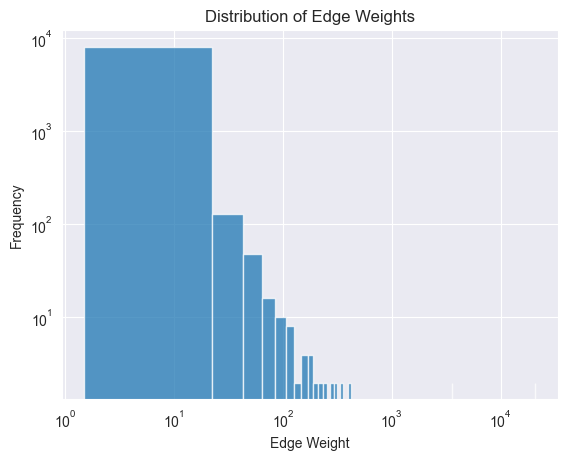

In [3]:
#Plot distribution of edge weights
import matplotlib.pyplot as plt
def plot_edge_weights_distribution(g):
    edge_weights = g.es['weight']
    plt.hist(edge_weights, bins=1000, alpha=0.75)
    plt.xlabel('Edge Weight')
    plt.ylabel('Frequency')
    plt.title('Distribution of Edge Weights')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True)
    plt.show()
    
plot_edge_weights_distribution(g)

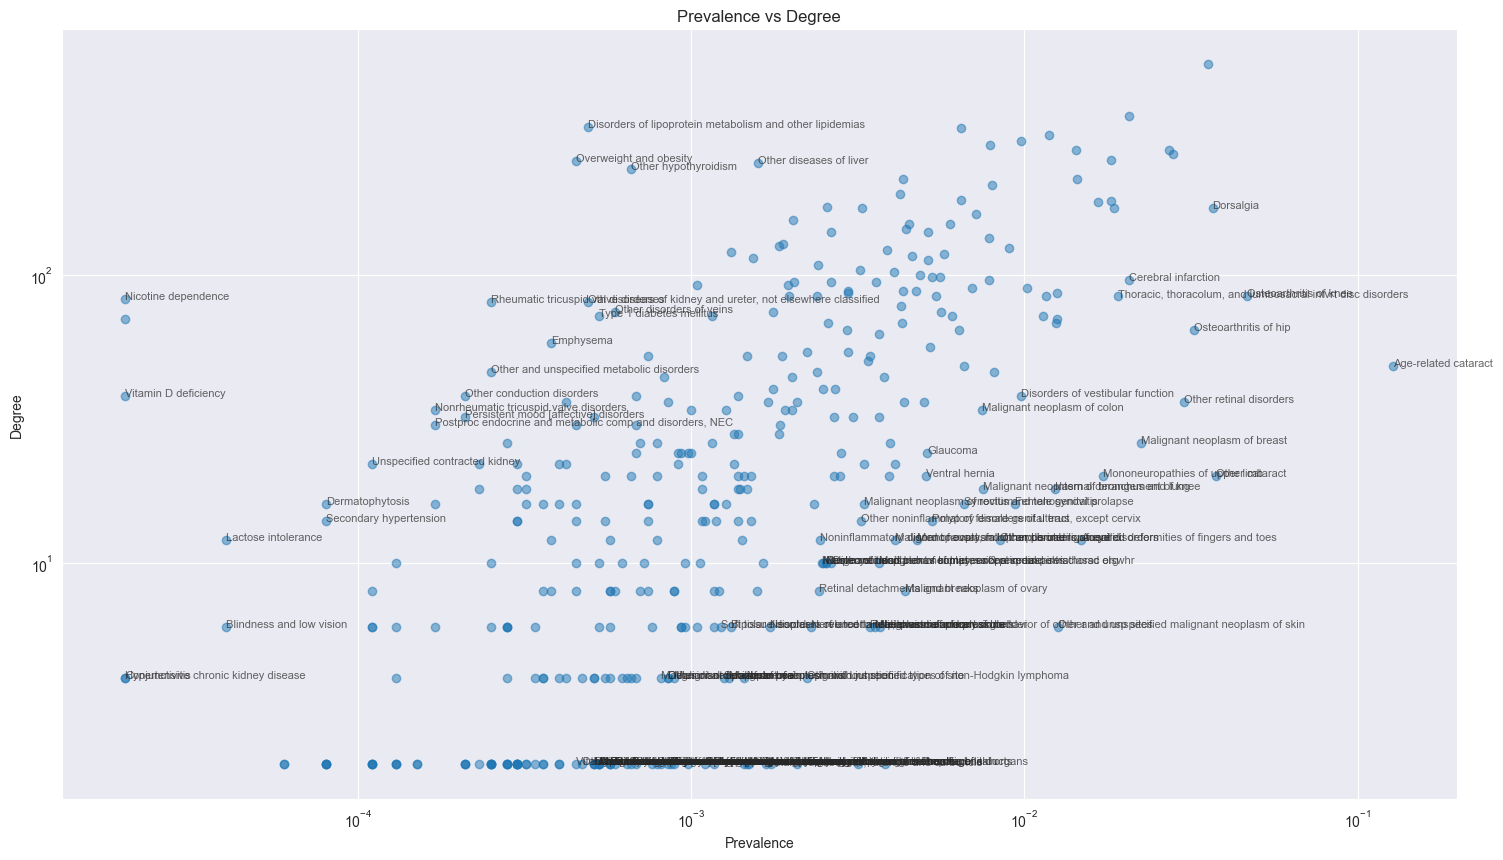

In [4]:
#Plot prevalence vs degree with correlation
def plot_prevalence_vs_degree(g):
    degrees = g.degree()
    prevalence = g.vs['prevalence']
    
    #Plot labels for outliers
    outliers = []
    threshold1 = 1E5  # Define a threshold for outliers  
    threshold2 = 0.5*1E4  # Define a threshold for prevalence
    for i in range(len(degrees)):
        if degrees[i] > threshold1 * prevalence[i] or degrees[i] < threshold2 * prevalence[i]:
            outliers.append(i)
    
    plt.figure(figsize=(18, 10))    
    plt.scatter(prevalence, degrees, alpha=0.5)
    for i in outliers:
        plt.annotate(g.vs[i]['description'], (prevalence[i], degrees[i]), fontsize=8, alpha=0.7)
    plt.ylabel('Degree')
    plt.xlabel('Prevalence')
    plt.title('Prevalence vs Degree')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True)
    plt.show()

plot_prevalence_vs_degree(g)

In [6]:
g2 = create_graph('Male', 'ICD', 'age_8')

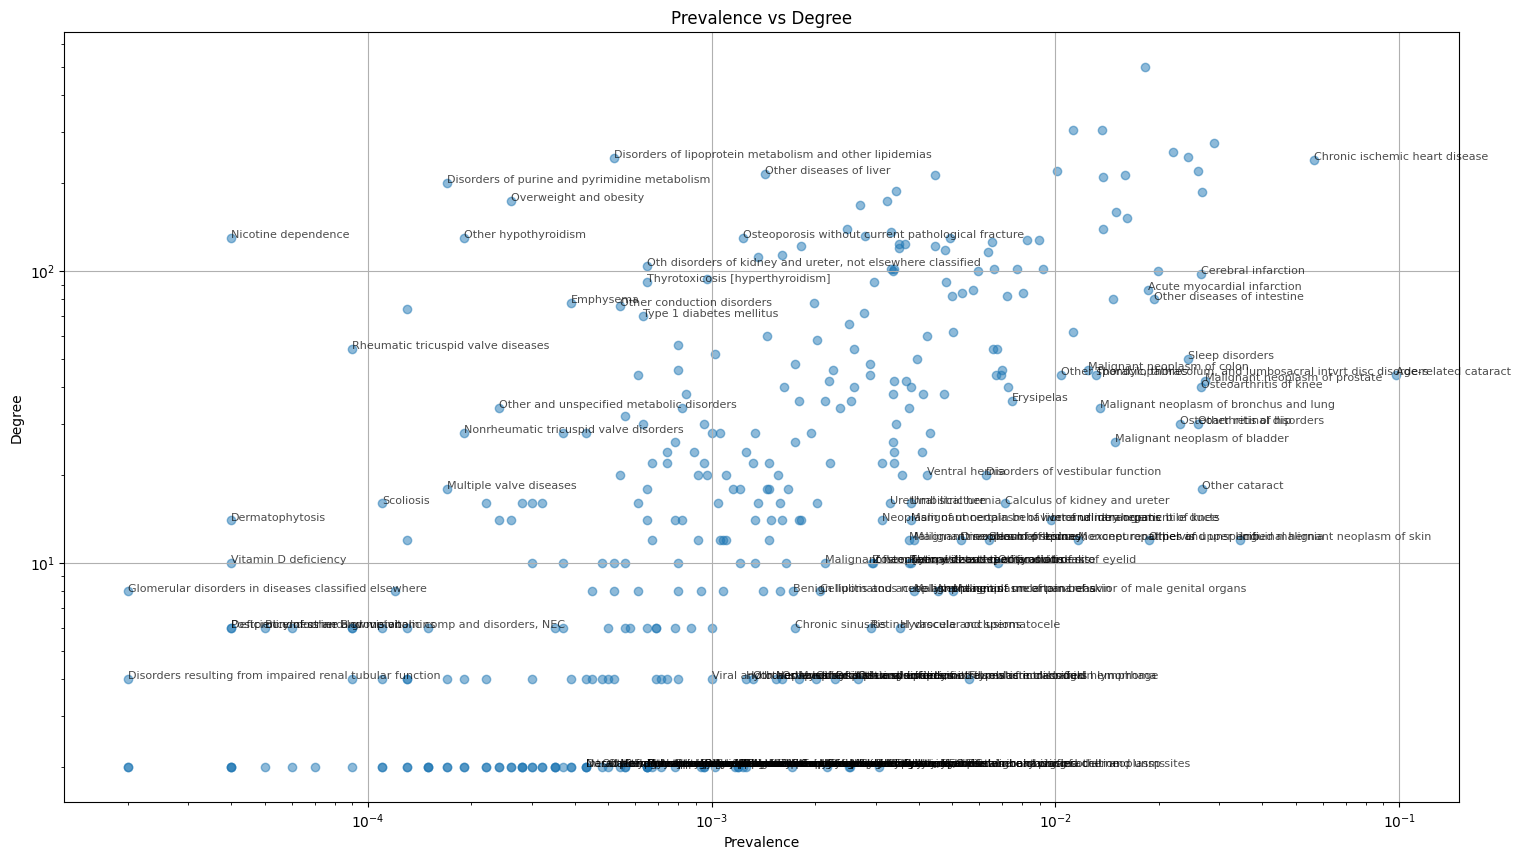

In [7]:
plot_prevalence_vs_degree(g2)

In [35]:
def deg_prev_df():
    columns = ['Sex', 'Age_Group', 'ICD_Code', 'ICD_Description', 'Degree', 'Prevalence']
    df = pd.DataFrame(columns=columns)
    for gender in ['Male', 'Female']:
        for a in ['1', '2', '3', '4', '5', '6', '7', '8']:
            age = f'age_{a}'

            print('Loading ' + gender + ' ' + age)
            g = create_graph(gender, 'ICD', age)
            
            icd_codes = g.vs['name']
            icd_desc = g.vs['description']
            degrees = g.degree()
            prevalence = g.vs['prevalence']
            # weights = g.es['weight']
            # w_degrees = [d * w for d, w in zip(degrees, weights)]
            # w_degrees = g.strength(weights=g.es['weight'])
            
            temp_df = pd.DataFrame({
                'Sex': gender,
                'Age_Group': age,
                'ICD_Code': icd_codes,
                'ICD_Description': icd_desc,
                'Degree': degrees,
                'Prevalence': prevalence
                # 'Weighted_Degree': w_degrees
            })
            
            df = pd.concat([df, temp_df], ignore_index=True)
    
    return df

In [36]:
df_deg_prev = deg_prev_df()

Loading Male age_1


C:\Users\Giovanni Palermo\AppData\Local\Temp\ipykernel_22592\539392976.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, temp_df], ignore_index=True)


Loading Male age_2
Loading Male age_3
Loading Male age_4
Loading Male age_5
Loading Male age_6
Loading Male age_7
Loading Male age_8
Loading Female age_1
Loading Female age_2
Loading Female age_3
Loading Female age_4
Loading Female age_5
Loading Female age_6
Loading Female age_7
Loading Female age_8


In [37]:
df_deg_prev.to_csv('Data\\Degree_Prevalence_ICD_raw.csv', index=False)

In [9]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch

def plot_all_icd_trajectories(df, sex=None, min_degree=0, min_prevalence=0, blocks=False, weighted=False, clusters=False):
    # Prepare the data
    if sex is not None:
        df = df[df['Sex'] == sex]
    df['Age_Index'] = df['Age_Group'].str.extract(r'age_(\d)').astype(int)
    
    if weighted:
        col = 'Weighted_Degree'
    else:
        col = 'Degree'
    
    # Filter by degree and prevalence
    df_filtered = df[(df['Degree'] >= min_degree) & (df['Prevalence'] >= min_prevalence)]
    
    xmin = df_filtered['Prevalence'].min() * 0.9
    xmax = df_filtered['Prevalence'].max() * 1.1
    ymin = df_filtered[col].min() * 0.9
    ymax = df_filtered[col].max() * 1.1
    
    icd_codes = df_filtered['ICD_Code'].unique()
    
    if blocks:
        block_df = pd.read_csv('Comorbidity-Networks-From-Population-Wide-Health-Data-main\\Blocks_All.csv')
        df_filtered = df_filtered.merge(block_df[['icd_code', 'block_id']], left_on='ICD_Code', right_on='icd_code', how='left')    

    plt.figure(figsize=(12, 10))
    plt.title("ICD Code Trajectories: Degree vs Prevalence", fontsize=16)
    plt.xlabel("Prevalence", fontsize=13)
    plt.ylabel(col, fontsize=13)

    color_map = {'Male': 'orange', 'Female': 'yellow'}
    if clusters: #color according to cluster
        clusters_number = df_filtered['DTW_Cluster'].nunique()
        color_map = {i: plt.cm.viridis(i / clusters_number) for i in range(clusters_number)}
    
    if not blocks:   
        for icd in icd_codes:
            icd_df = df_filtered[df_filtered['ICD_Code'] == icd]
            
            for sex in ['Male', 'Female']:
                sub = icd_df[icd_df['Sex'] == sex].sort_values('Age_Index')
                if len(sub) < 2:
                    continue  # Need at least 2 points to draw an arrow
    
                # Draw arrows between consecutive age points
                for i in range(len(sub) - 1):
                    x1, y1 = sub.iloc[i]['Prevalence'], sub.iloc[i][col]
                    x2, y2 = sub.iloc[i+1]['Prevalence'], sub.iloc[i+1][col]
                    
                    if clusters:
                        arrow = FancyArrowPatch((x1, y1), (x2, y2),
                                                color=color_map[sub.iloc[i]['DTW_Cluster']],
                                                arrowstyle='->',
                                                mutation_scale=10,
                                                alpha=0.6,
                                                linewidth=1)
                    else:
                        arrow = FancyArrowPatch((x1, y1), (x2, y2),
                                                color=color_map[sex],
                                                arrowstyle='->',
                                                mutation_scale=10,
                                                alpha=0.6,
                                                linewidth=1)
                        
                    plt.gca().add_patch(arrow)
                
                                # 🔽 Add label at the end of the last arrow
                x_end = sub.iloc[-1]['Prevalence']
                y_end = sub.iloc[-1][col]
                label = f"{icd}"  # You could make this block name if available
                
                if clusters:
                    plt.text(x_end, y_end, label,
                             fontsize=12,
                             color=color_map[sub.iloc[-1]['DTW_Cluster']],
                             ha='left',
                             va='center',
                             alpha=0.9)
                else:
                    plt.text(x_end, y_end, label,
                             fontsize=12,
                             color=color_map[sex],
                             ha='left',
                             va='center',
                             alpha=0.9)
    else:
        df_filtered = (df_filtered
                        .groupby(['block_id', 'Sex', 'Age_Index'], as_index=False)
                        .agg({
                            'Prevalence': 'mean',
                            col: 'mean'
                        })
                    )
        for block in df_filtered['block_id'].unique():
            icd_df = df_filtered[df_filtered['block_id'] == block]

            for sex in ['Male', 'Female']:
                sub = icd_df[icd_df['Sex'] == sex].sort_values('Age_Index')
                if len(sub) < 2:
                    continue  # Need at least 2 points to draw an arrow
    
                # Draw arrows between consecutive age points
                for i in range(len(sub) - 1):
                    x1, y1 = sub.iloc[i]['Prevalence'], sub.iloc[i][col]
                    x2, y2 = sub.iloc[i+1]['Prevalence'], sub.iloc[i+1][col]
    
                    if clusters:
                        arrow = FancyArrowPatch((x1, y1), (x2, y2),
                                                color=color_map[sub.iloc[i]['DTW_Cluster']],
                                                arrowstyle='->',
                                                mutation_scale=10,
                                                alpha=0.6,
                                                linewidth=1)
                    else:
                        arrow = FancyArrowPatch((x1, y1), (x2, y2),
                                                color=color_map[sex],
                                                arrowstyle='->',
                                                mutation_scale=10,
                                                alpha=0.6,
                                                linewidth=1)
                    plt.gca().add_patch(arrow)
                
                # 🔽 Add label at the end of the last arrow
                x_end = sub.iloc[-1]['Prevalence']
                y_end = sub.iloc[-1][col]
                label = f"{block}"  # You could make this block name if available
        
                plt.text(x_end, y_end, label,
                         fontsize=12,
                         color=color_map[sex],
                         ha='left',
                         va='center',
                         alpha=0.9)
            
            

    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
                    

    # Add a legend manually
    if clusters:
        for cluster in range(len(color_map)):
            plt.plot([], [], color=color_map[cluster], label=f'Cluster {cluster}')
    else:
        for sex in ['Male', 'Female']:
            plt.plot([], [], color=color_map[sex], label=sex)
        plt.legend(title="Sex")

    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xscale('log')
    plt.yscale('log')
    plt.tight_layout()
    plt.show()


C:\Users\Giovanni Palermo\AppData\Local\Temp\ipykernel_22592\2036016487.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Age_Index'] = df['Age_Group'].str.extract(r'age_(\d)').astype(int)


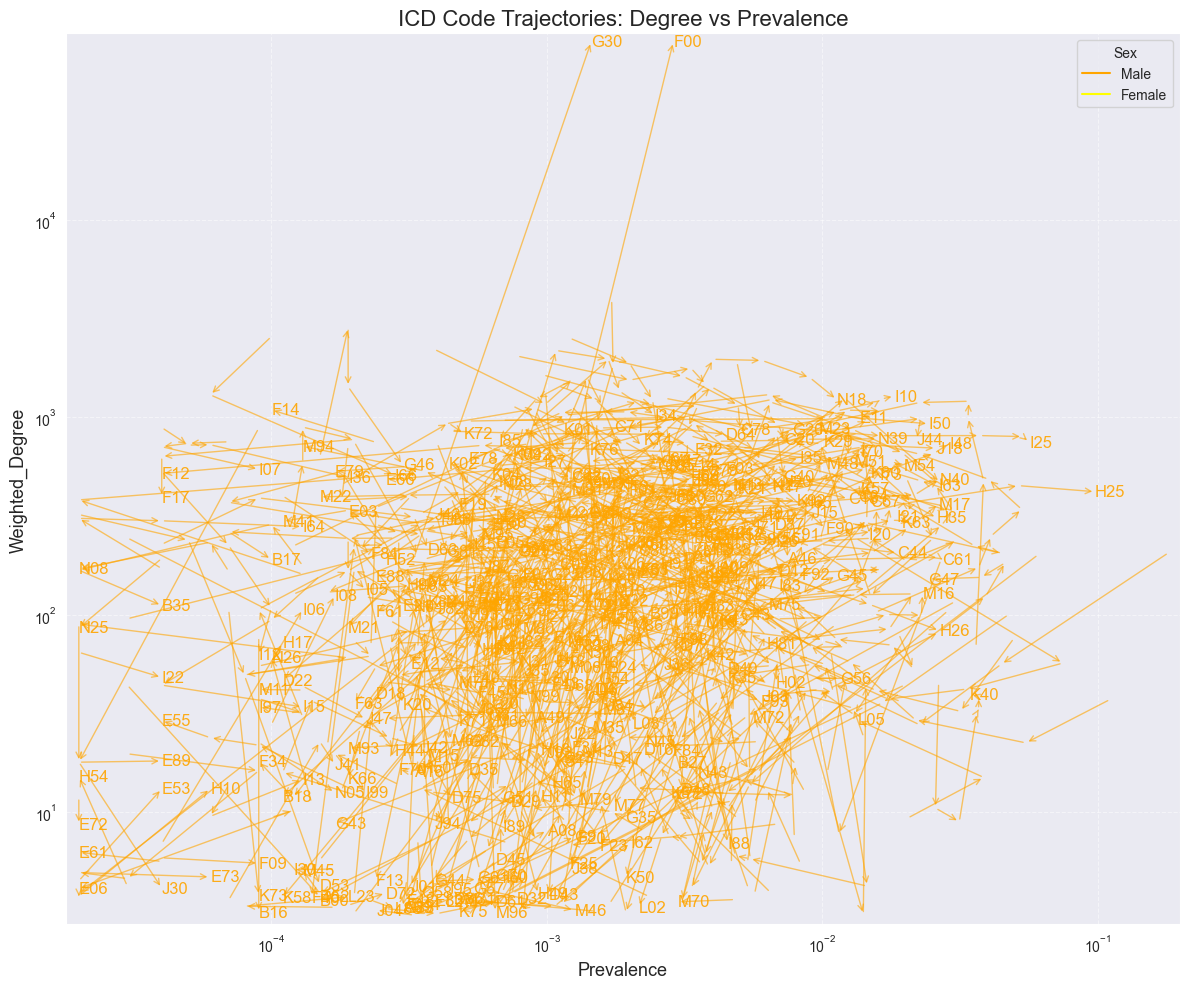

C:\Users\Giovanni Palermo\AppData\Local\Temp\ipykernel_22592\2036016487.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Age_Index'] = df['Age_Group'].str.extract(r'age_(\d)').astype(int)


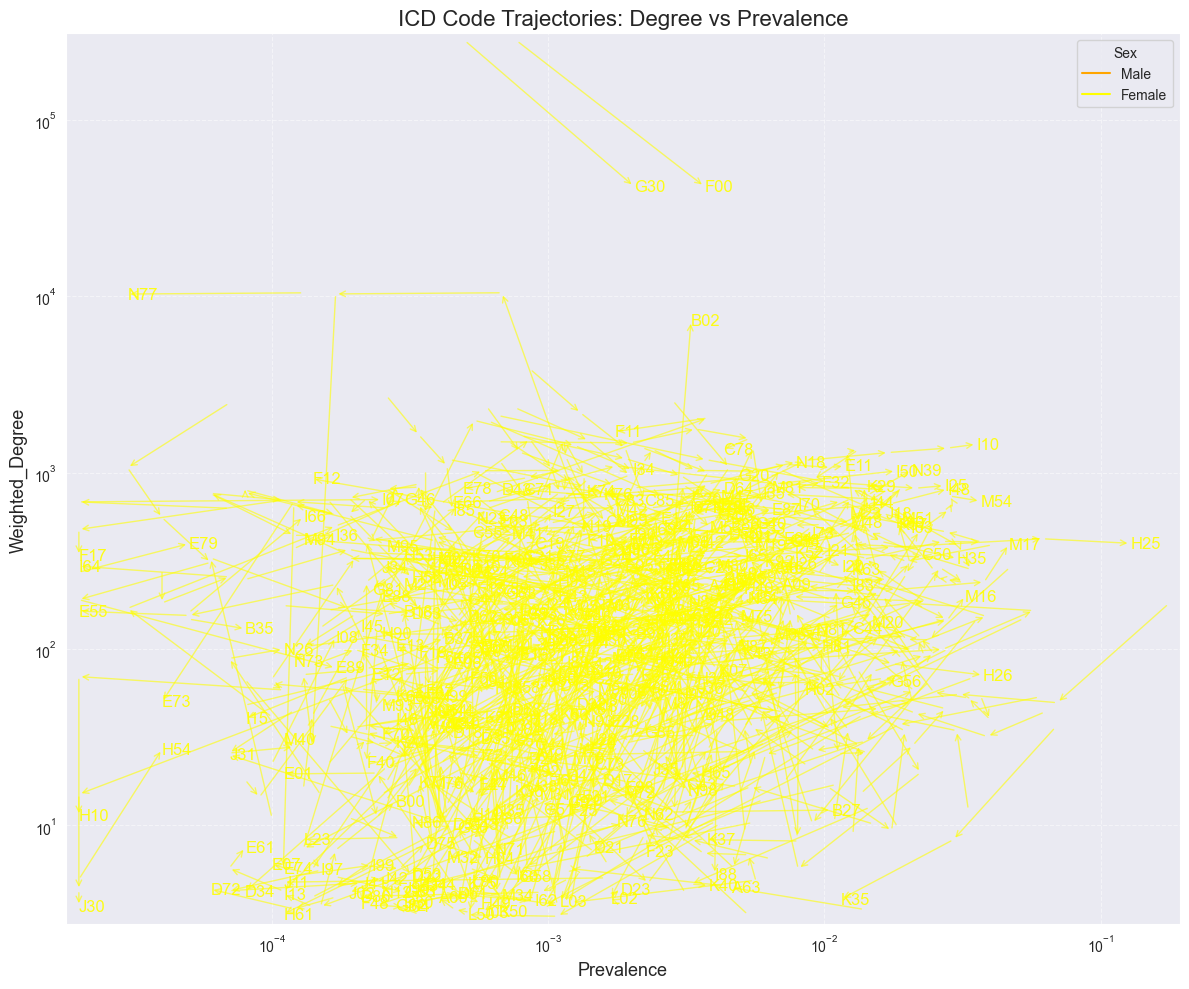

In [10]:
# Plot all ICD trajectories with degree and prevalence
plot_all_icd_trajectories(df_deg_prev, sex='Male', min_degree=1, min_prevalence=0.0000001, blocks=False, weighted=True)
plot_all_icd_trajectories(df_deg_prev, sex='Female', min_degree=1, min_prevalence=0.0000001, blocks=False, weighted=True)

In [78]:
import numpy as np
df_deg_prev = pd.read_csv('Data\\Degree_Prevalence_ICD_raw.csv')
#delete zero prevalence
df_deg_prev = df_deg_prev[df_deg_prev['Prevalence'] > 0]
df_deg_prev['Ratio'] = df_deg_prev['Degree'] / df_deg_prev['Prevalence']
df_deg_prev['Log_ratio'] = df_deg_prev['Ratio'].apply(lambda x: np.log10(x) if x > 0 else np.nan)
# df_deg_prev['W_ratio'] = df_deg_prev['Weighted_Degree'] / df_deg_prev['Prevalence']
# df_deg_prev['W_Log_ratio'] = df_deg_prev['W_ratio'].apply(lambda x: np.log10(x) if x > 0 else np.nan)
df_deg_prev

,Sex,Age_Group,ICD_Code,ICD_Description,Degree,Prevalence,Ratio,Log_ratio
2,Male,age_1,A02,Other salmonella infections,2,0.00172,1162.790698,3.065502
3,Male,age_1,A03,Shigellosis,0,0.00003,0.000000,NaN
4,Male,age_1,A04,Other bacterial intestinal infections,6,0.00402,1492.537313,3.173925
5,Male,age_1,A05,"Oth bacterial foodborne intoxications, NEC",0,0.00006,0.000000,NaN
6,Male,age_1,A06,Amebiasis,0,0.00003,0.000000,NaN
...,...,...,...,...,...,...,...,...
17027,Female,age_8,N92,"Excessive, frequent and irregular menstruation",0,0.00004,0.000000,NaN
17028,Female,age_8,N93,Other abnormal uterine and vaginal bleeding,0,0.00023,0.000000,NaN
17029,Female,age_8,N94,Pain and oth cond assoc w fem gntl org and men...,0,0.00008,0.000000,NaN
17030,Female,age_8,N95,Menopausal and other perimenopausal disorders,12,0.00476,2521.008403,3.401574


In [12]:
#Plot log ratio distribution
def plot_log_ratio_distribution(df, weighted=False):
    if weighted:
        pref = 'W_'
    else:
        pref = ''
    #Print mean and std
    mean_log_ratio = df[pref+'Log_ratio'].mean()
    std_log_ratio = df[pref+'Log_ratio'].std()
    if weighted:
        print(f"Mean Weighted Log Ratio: {mean_log_ratio:.2f}, Std Weighted Log Ratio: {std_log_ratio:.2f}")
    else:
        print(f"Mean Log Ratio: {mean_log_ratio:.2f}, Std Log Ratio: {std_log_ratio:.2f}")
    plt.figure(figsize=(10, 6))
    plt.hist(df[pref+'Log_ratio'].dropna(), bins=100, alpha=0.75)
    plt.xlabel('Log10('+pref+'Degree / Prevalence)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Log10('+pref+'Degree / Prevalence)')
    plt.xscale('linear')
    plt.grid(True)
    plt.show()

Mean Log Ratio: 3.80, Std Log Ratio: 0.67


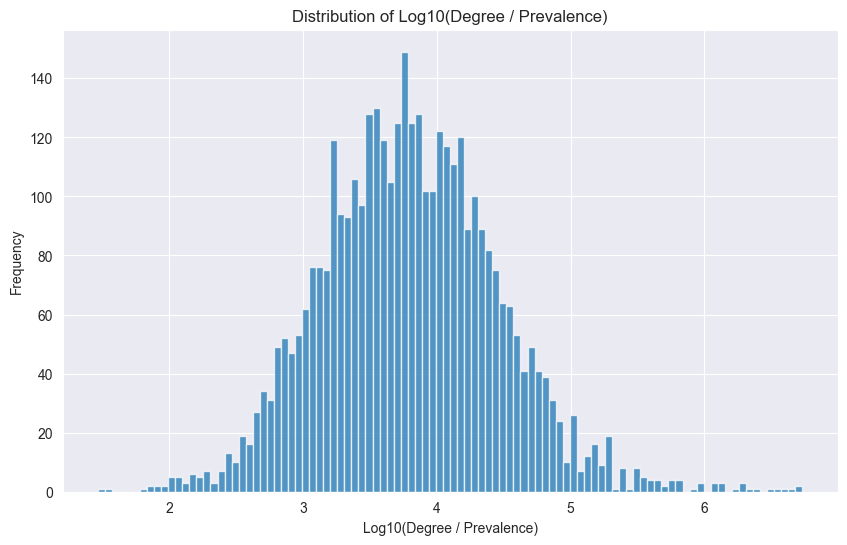

In [39]:
plot_log_ratio_distribution(df_deg_prev, weighted=False)

In [79]:
# for pref in ['', 'W_']:
#     # mean_log_ratio = df_deg_prev[pref+'Log_ratio'].mean()
#     # std_log_ratio = df_deg_prev[pref+'Log_ratio'].std()
#     # df_deg_prev[pref+'Deviation'] = (df_deg_prev[pref+'Log_ratio'] - mean_log_ratio) / std_log_ratio
#     # df_deg_prev[pref+'Outlier'] = df_deg_prev[pref+'Deviation'].abs() > 3
#     #interquartile distance of log ratio
#     q1 = df_deg_prev[pref+'Log_ratio'].quantile(0.25)
#     q3 = df_deg_prev[pref+'Log_ratio'].quantile(0.75)
#     iqr = q3 - q1
#     lower_bound = q1 - 1.75 * iqr
#     upper_bound = q3 + 1.75 * iqr
#     df_deg_prev[pref+'Outlier'] = (df_deg_prev[pref+'Log_ratio'] < lower_bound) | (df_deg_prev[pref+'Log_ratio'] > upper_bound)
#     df_out = pd.DataFrame(columns = df_deg_prev.columns)
#     
#     for sex in ['Male', 'Female']:
#         for icd_code in df_deg_prev['ICD_Code'].unique():
#             df_icd = df_deg_prev[(df_deg_prev['Sex'] == sex) & (df_deg_prev['ICD_Code'] == icd_code)]
#             if True in df_icd[pref+'Outlier'].values:
#                 df_out = pd.concat([df_out, df_icd], ignore_index=True)

def deviation(log_ratio, upper_bound, lower_bound, distance):
    if log_ratio < lower_bound:
        return (log_ratio - lower_bound) / distance
    elif log_ratio > upper_bound:
        return (log_ratio - upper_bound) / distance
    else:
        return 0

def modified_zscore(x, median, mad):
    return 0.6745 * (x - median) / mad

    
def find_outliers(df, weighted=False):
    if weighted:
        pref = 'W_'
    else:
        pref = ''
    
    # mean_log_ratio = df[pref+'Log_ratio'].mean()
    # std_log_ratio = df[pref+'Log_ratio'].std()
    # df[pref+'Deviation'] = (df[pref+'Log_ratio'] - mean_log_ratio) / std_log_ratio
    # df[pref+'Outlier'] = df[pref+'Deviation'].abs() > 2
    
    df_out = pd.DataFrame(columns = df.columns)
    for sex in ['Male', 'Female']:
        for age_id in df['Age_Group'].unique():
            df_icd = df[(df['Sex'] == sex) & (df['Age_Group'] == age_id)]
            # q1 = df_icd[pref+'Log_ratio'].quantile(0.25)
            # q3 = df_icd[pref+'Log_ratio'].quantile(0.75)
            # iqr = q3 - q1
            # lower_bound = q1 - 1.5 * iqr
            # upper_bound = q3 + 1.5 * iqr
            # distance = upper_bound - lower_bound
            lower_bound = df_icd[pref+'Log_ratio'].quantile(0.05)
            upper_bound = df_icd[pref+'Log_ratio'].quantile(0.95)
            median = df_icd[pref+'Log_ratio'].median()
            mad = (df_icd[pref+'Log_ratio'] - median).abs().median()
            # df_icd[pref+'Deviation'] = df_icd[pref+'Log_ratio'].apply(lambda x: deviation(x, upper_bound, lower_bound, distance))
            df_icd[pref+'Deviation'] = df_icd[pref+'Log_ratio'].apply(lambda x: modified_zscore(x, median, mad))
            
            df_icd[pref+'Outlier'] = (df_icd[pref+'Log_ratio'] < lower_bound) | (df_icd[pref+'Log_ratio'] > upper_bound)
            df_out = pd.concat([df_out, df_icd], ignore_index=True)
    
    return df_out

# df_deg_prev.drop(columns=['Weighted_Degree', 'W_Deviation', 'W_Outlier', 'W_Log_ratio', 'W_ratio'], inplace=True, errors='ignore')

df_deg_prev = find_outliers(df_deg_prev, weighted=False)
df_deg_prev

C:\Users\Giovanni Palermo\AppData\Local\Temp\ipykernel_22592\35676131.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_icd[pref+'Deviation'] = df_icd[pref+'Log_ratio'].apply(lambda x: modified_zscore(x, median, mad))
C:\Users\Giovanni Palermo\AppData\Local\Temp\ipykernel_22592\35676131.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_icd[pref+'Outlier'] = (df_icd[pref+'Log_ratio'] < lower_bound) | (df_icd[pref+'Log_ratio'] > upper_bound)
C:\Users\Giovanni Palermo\AppData\Local\Temp\ipykernel_2

,Sex,Age_Group,ICD_Code,ICD_Description,Degree,Prevalence,Ratio,Log_ratio,Deviation,Outlier
0,Male,age_1,A02,Other salmonella infections,2,0.00172,1162.790698,3.065502,-0.776868,False
1,Male,age_1,A03,Shigellosis,0,0.00003,0.000000,NaN,NaN,False
2,Male,age_1,A04,Other bacterial intestinal infections,6,0.00402,1492.537313,3.173925,-0.545188,False
3,Male,age_1,A05,"Oth bacterial foodborne intoxications, NEC",0,0.00006,0.000000,NaN,NaN,False
4,Male,age_1,A06,Amebiasis,0,0.00003,0.000000,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...
11584,Female,age_8,N92,"Excessive, frequent and irregular menstruation",0,0.00004,0.000000,NaN,NaN,False
11585,Female,age_8,N93,Other abnormal uterine and vaginal bleeding,0,0.00023,0.000000,NaN,NaN,False
11586,Female,age_8,N94,Pain and oth cond assoc w fem gntl org and men...,0,0.00008,0.000000,NaN,NaN,False
11587,Female,age_8,N95,Menopausal and other perimenopausal disorders,12,0.00476,2521.008403,3.401574,-1.409256,False


In [80]:
df_deg_prev.to_csv('Data\\Degree_Prevalence_ICD.csv', index=False)

C:\Users\Giovanni Palermo\AppData\Local\Temp\ipykernel_6448\441422629.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Age_Index'] = df['Age_Group'].str.extract(r'age_(\d)').astype(int)


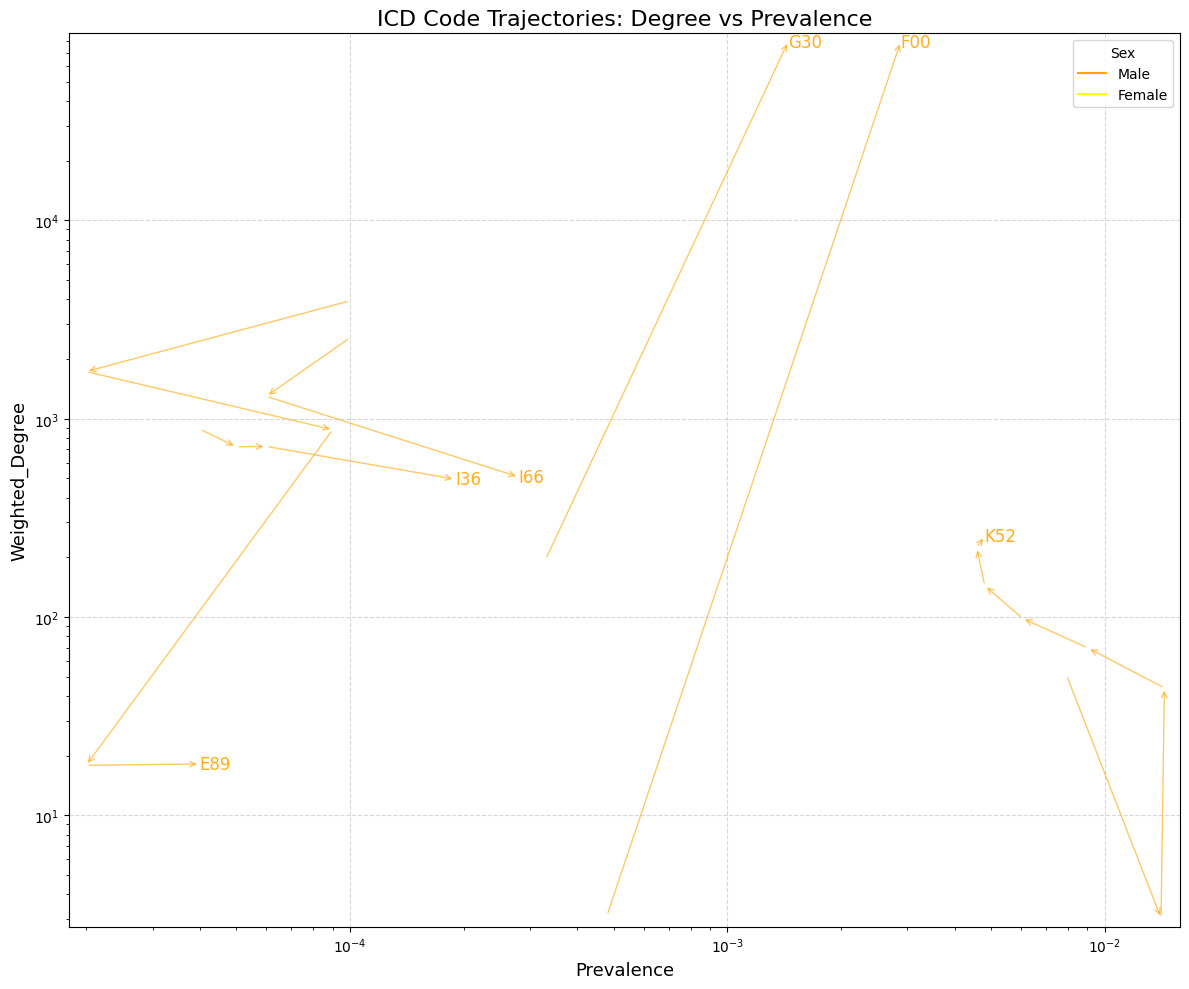

C:\Users\Giovanni Palermo\AppData\Local\Temp\ipykernel_6448\441422629.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Age_Index'] = df['Age_Group'].str.extract(r'age_(\d)').astype(int)


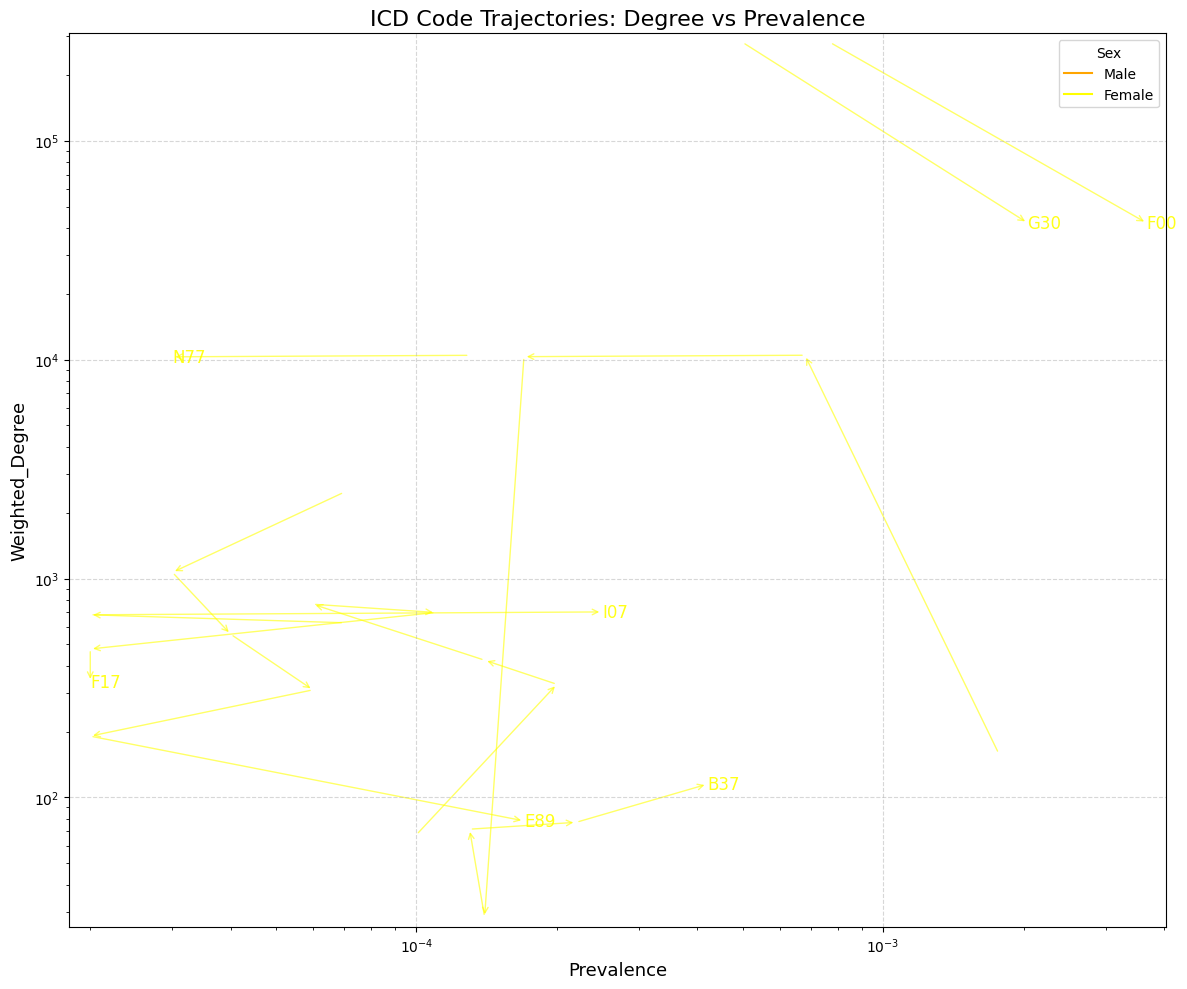

In [39]:
plot_all_icd_trajectories(df_out, 'Male', 1E-10, 1E-10, blocks=False, weighted=True)
plot_all_icd_trajectories(df_out, 'Female', 1E-10, 1E-10, blocks=False, weighted=True)

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
df_deg_prev = pd.read_csv('Data\\Degree_Prevalence_ICD.csv')

In [76]:
def find_outliers(df, weighted=False):
    if weighted:
        pref = 'W_'
    else:
        pref = ''
    
    # mean_log_ratio = df[pref+'Log_ratio'].mean()
    # std_log_ratio = df[pref+'Log_ratio'].std()
    # df[pref+'Deviation'] = (df[pref+'Log_ratio'] - mean_log_ratio) / std_log_ratio
    # df[pref+'Outlier'] = df[pref+'Deviation'].abs() > 2
    q1 = df[pref+'Log_ratio'].quantile(0.25)
    q3 = df[pref+'Log_ratio'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    df[pref+'Outlier'] = (df[pref+'Log_ratio'] < lower_bound) | (df[pref+'Log_ratio'] > upper_bound)
    
    df_out = pd.DataFrame(columns = df.columns)
    for sex in ['Male', 'Female']:
        for icd_code in df['ICD_Code'].unique():
            df_icd = df[(df['Sex'] == sex) & (df['ICD_Code'] == icd_code)]
            if True in df_icd[pref+'Outlier'].values:
                df_out = pd.concat([df_out, df_icd], ignore_index=True)
    
    return df_out

def plot_outlier_snaps(df, weighted=False, save=False):
    fig, ax = plt.subplots(2, 8, figsize=(32, 8))
    fig.suptitle('Outlier Snapshots', fontsize=16)
    df['Age_Index'] = df['Age_Group'].str.extract(r'age_(\d)').astype(int)
    
    if weighted:
        col = 'Weighted_Degree'
    else:
        col = 'Degree'
    
    age_dict = {'age_1': '0-9', 'age_2': '10-19', 'age_3': '20-29', 
            'age_4': '30-39', 'age_5': '40-49', 'age_6': '50-59', 
            'age_7': '60-69', 'age_8': '70-79', 'age_9': '80+'}
    
    from adjustText import adjust_text
    
    for i, sex in enumerate(['Male', 'Female']):
        for j, age_id in enumerate(df['Age_Index'].unique()):
            df_filt = df[(df['Sex'] == sex) & (df['Age_Index'] == age_id)]
            # df_filt = find_outliers(df_filt, weighted=weighted)
            # display(df_filt)
            ax[i,j].set_title(sex + ' Age ' + age_dict[f'age_{age_id}'], fontsize=14)
    
            if df_filt.empty:
                continue
    
            x = df_filt['Prevalence']
            y = df_filt[col]
            labels = df_filt['ICD_Code']
            size = df_filt['Deviation'].abs() * 100  # Scale size for visibility, adjust as needed
            # Scatter plot
            ax[i,j].scatter(x, y, s=size, alpha=0.5)
            
            for idx, label in enumerate(labels):
                ax[i,j].annotate(label, (x.iloc[idx], y.iloc[idx]), fontsize=10, alpha=0.7)
            
            # for idx, row in df_filt.iterrows():
            #     ax[i,j].annotate(row['ICD_Code'], (row['Prevalence'], row[col]), fontsize=14, alpha=0.5)
    
            # texts = []
            # for idx, row in df_filt.iterrows():
            #     texts.append(ax[i,j].annotate(row['ICD_Code'], (row['Prevalence'], row[col]), fontsize=10, alpha=0.7))
            # 
            # adjust_text(
            #     texts,
            #     ax=ax[i,j],
            #     max_iterations=10,
            #     expand_text=(1.05, 1.2),
            #     expand_points=(1.05, 1.2),
            #     only_move={'points': 'y', 'texts': 'y'},
            #     arrowprops=dict(arrowstyle='-', color='gray', lw=0.5),
            #     autoalign=False
            # )
            
            if not weighted:
                ax[i, j].set_xlim(1E-5, 1)
                ax[i, j].set_ylim(1, 1E3)
            else:
                ax[i, j].set_xlim(1E-5, 1)
                ax[i, j].set_ylim(1, 1E6)
    
            ax[i,j].set_xscale('log')
            ax[i,j].set_yscale('log')


    if save:
        if weighted:
            plt.savefig('Outlier_Snapshots_Weighted.pdf', bbox_inches='tight')
        else:
            plt.savefig('Outlier_Snapshots.pdf', bbox_inches='tight')
    plt.show()
            

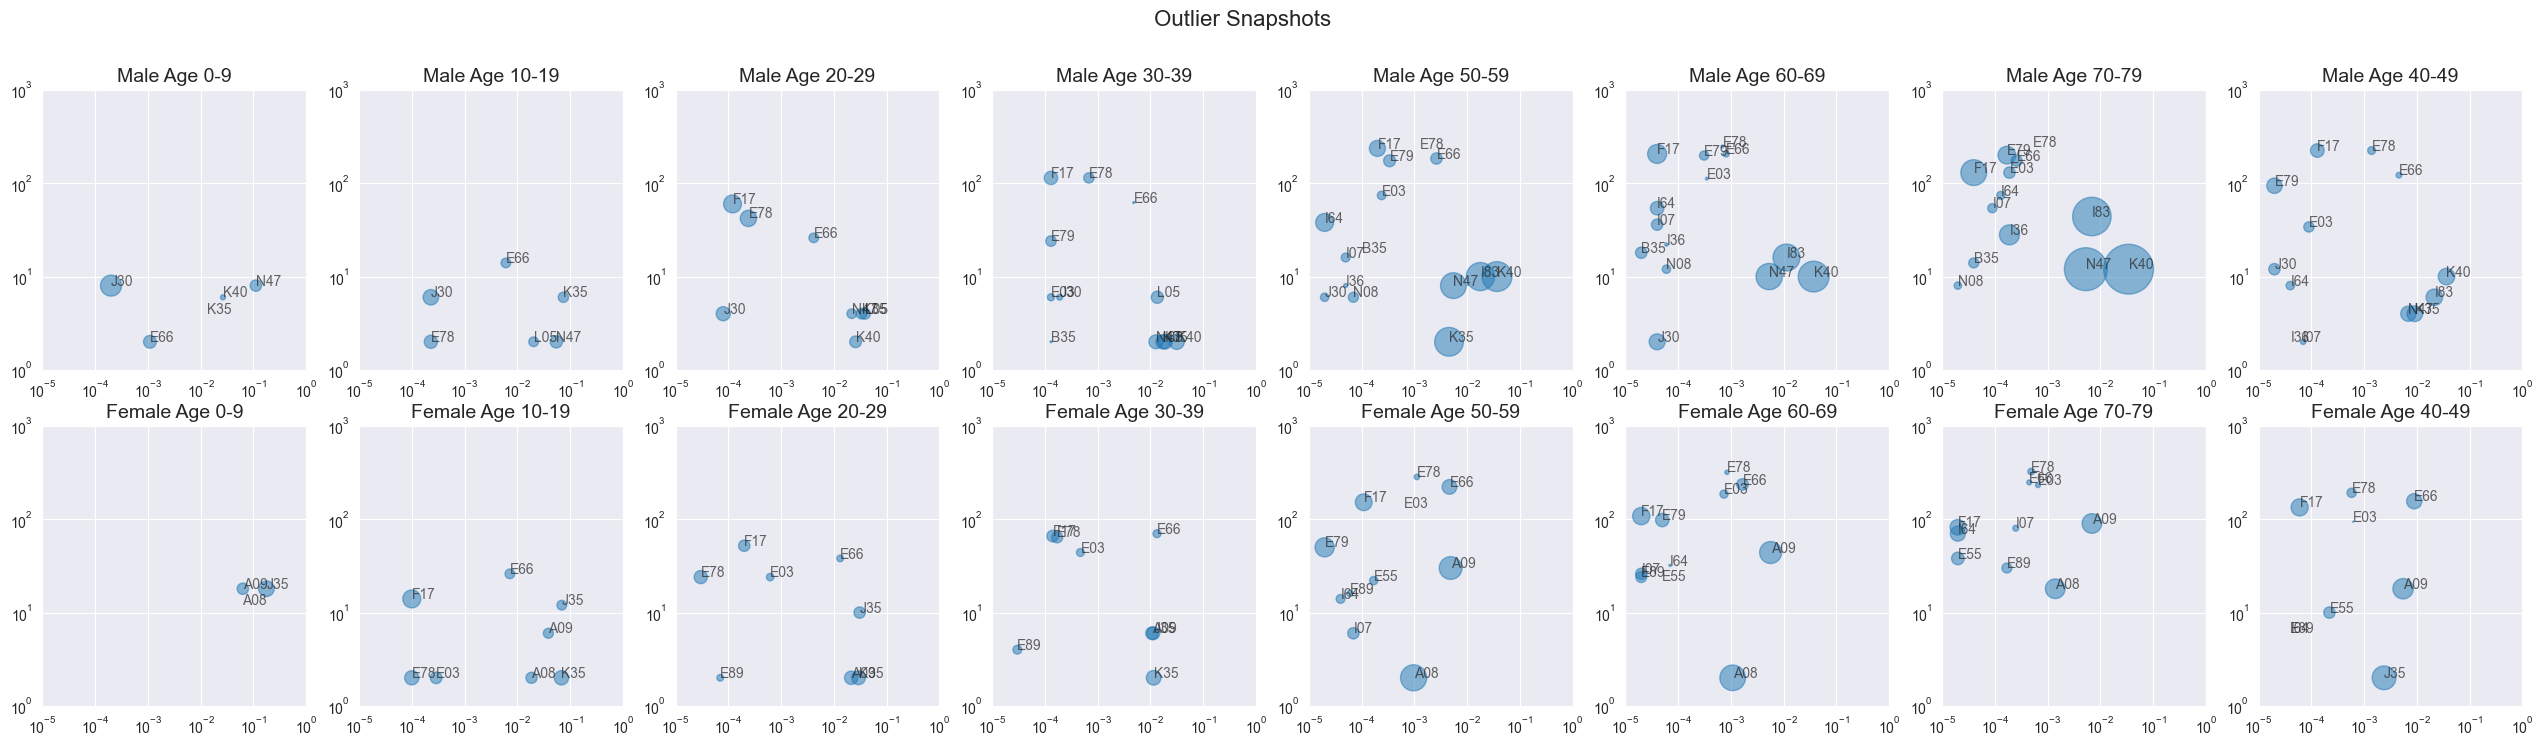

In [77]:
plot_outlier_snaps(df_deg_prev, save=True, weighted=False)

In [98]:
df_deg_prev

,Sex,Age_Group,ICD_Code,ICD_Description,Degree,Prevalence,Weighted_Degree,Age_Index,Ratio,Log_ratio,W_ratio,W_Log_ratio
0,Male,age_1,A01,Typhoid and paratyphoid fevers,0,0.00011,0.000000,1,0.000000,NaN,0.000000,NaN
1,Male,age_1,A02,Other salmonella infections,2,0.00172,6.774610,1,1162.790698,3.065502,3938.726915,3.595356
2,Male,age_1,A03,Shigellosis,0,0.00003,0.000000,1,0.000000,NaN,0.000000,NaN
3,Male,age_1,A04,Other bacterial intestinal infections,6,0.00402,14.202501,1,1492.537313,3.173925,3532.960391,3.548139
4,Male,age_1,A05,"Oth bacterial foodborne intoxications, NEC",0,0.00006,0.000000,1,0.000000,NaN,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
14704,Female,age_8,N93,Other abnormal uterine and vaginal bleeding,0,0.00023,0.000000,8,0.000000,NaN,0.000000,NaN
14705,Female,age_8,N94,Pain and oth cond assoc w fem gntl org and men...,0,0.00008,0.000000,8,0.000000,NaN,0.000000,NaN
14706,Female,age_8,N95,Menopausal and other perimenopausal disorders,12,0.00476,246.539439,8,2521.008403,3.401574,51793.999826,4.714279
14707,Female,age_8,N97,Female infertility,0,0.00004,0.000000,8,0.000000,NaN,0.000000,NaN


In [94]:
def trajectory_deltas(traj):
    return np.diff(traj, axis=0)  # first differences

def cluster_icd_trajectories_with_labels(df, min_age_index=4, n_clusters=3, n_points=10):
    """
    Filters ICD codes for all age indexes >= min_age_index (per sex),
    clusters (Degree, Prevalence) trajectories using DTW,
    and returns the original DataFrame with cluster labels.

    Returns:
        pd.DataFrame: Original DataFrame with 'DTW_Cluster' column added
    """
    from collections import defaultdict
    import numpy as np
    import pandas as pd
    from tslearn.clustering import TimeSeriesKMeans
    from tslearn.preprocessing import TimeSeriesResampler

    df_out = df.copy()
    df_out['DTW_Cluster'] = np.nan  # Default as NaN
    
    df = df[df['Degree'] > 0]
    df = df[df['Prevalence'] > 0]
    
    df['Degree'] = df['Degree'].apply(lambda x: np.log10(x))
    df['Prevalence'] = df['Prevalence'].apply(lambda x: np.log10(x))
    
    display(df)

    for sex in ['Male', 'Female']:
        # Filter by sex and age index
        df_sex = df[(df['Sex'] == sex) & (df['Age_Index'] >= min_age_index)]

        # Find ICD codes present in all relevant age indexes
        age_groups = df_sex['Age_Index'].unique()
        icd_counts = df_sex.groupby('ICD_Code')['Age_Index'].nunique()
        valid_icds = icd_counts[icd_counts == len(age_groups)].index

        # Filter valid data
        df_valid = df_sex[df_sex['ICD_Code'].isin(valid_icds)]

        # Build trajectories
        icd_trajectories = {}
        for icd in valid_icds:
            df_icd = df_valid[df_valid['ICD_Code'] == icd].sort_values('Age_Index')
            trajectory = df_icd[['Degree', 'Prevalence']].to_numpy()
            icd_trajectories[icd] = trajectory

        # Prepare for DTW clustering
        all_trajectories = list(icd_trajectories.values())
        max_len = max(len(t) for t in all_trajectories)
        padded = np.array([
            np.pad(traj, ((0, max_len - len(traj)), (0, 0)), mode='edge')
            for traj in all_trajectories
        ])
        # ts_resampled = TimeSeriesResampler(sz=n_points).fit_transform(padded)
        delta_trajectories = np.array([trajectory_deltas(traj) for traj in all_trajectories])
        ts_resampled = TimeSeriesResampler(sz=n_points - 1).fit_transform(delta_trajectories)


        # Cluster using DTW
        model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=0)
        labels = model.fit_predict(ts_resampled)

        # Assign labels back to original DataFrame
        icd_list = list(icd_trajectories.keys())
        for icd_code, label in zip(icd_list, labels):
            idx = (df_out['Sex'] == sex) & (df_out['ICD_Code'] == icd_code) & (df_out['Age_Index'] >= min_age_index)
            df_out.loc[idx, 'DTW_Cluster'] = label

    # Convert cluster column to int (optional)
    df_out['DTW_Cluster'] = df_out['DTW_Cluster'].astype('Int64')

    return df_out


In [95]:
df_traj = cluster_icd_trajectories_with_labels(df_deg_prev, min_age_index=4, n_clusters=3, n_points=10)
df_traj

,Sex,Age_Group,ICD_Code,ICD_Description,Degree,Prevalence,Weighted_Degree,Age_Index,Ratio,Log_ratio,W_ratio,W_Log_ratio
1,Male,age_1,A02,Other salmonella infections,0.301030,-2.764472,6.774610,1,1162.790698,3.065502,3938.726915,3.595356
3,Male,age_1,A04,Other bacterial intestinal infections,0.778151,-2.395774,14.202501,1,1492.537313,3.173925,3532.960391,3.548139
7,Male,age_1,A08,Viral and other specified intestinal infections,1.505150,-1.323489,100.130361,1,673.967987,2.828639,2108.895566,3.324055
8,Male,age_1,A09,"Infectious gastroenteritis and colitis, unspec...",1.447158,-1.303993,75.932130,1,563.834072,2.751151,1529.040070,3.184419
25,Male,age_1,A41,Other sepsis,0.903090,-2.612610,82.603798,1,3278.688525,3.515700,33854.015746,4.529610
...,...,...,...,...,...,...,...,...,...,...,...,...
14694,Female,age_8,N83,"Noninflammatory disord of ovary, fallop and br...",1.079181,-2.612610,144.436658,8,4918.032787,3.691791,59195.351639,4.772288
14695,Female,age_8,N84,Polyp of female genital tract,1.146128,-2.276544,194.007731,8,2646.502836,3.422672,36674.429348,4.564363
14696,Female,age_8,N85,"Other noninflammatory disorders of uterus, exc...",1.146128,-2.490797,186.872034,8,4334.365325,3.636926,57855.118852,4.762342
14706,Female,age_8,N95,Menopausal and other perimenopausal disorders,1.079181,-2.322393,246.539439,8,2521.008403,3.401574,51793.999826,4.714279


,Sex,Age_Group,ICD_Code,ICD_Description,Degree,Prevalence,Weighted_Degree,Age_Index,Ratio,Log_ratio,W_ratio,W_Log_ratio,DTW_Cluster
0,Male,age_1,A01,Typhoid and paratyphoid fevers,0,0.00011,0.000000,1,0.000000,NaN,0.000000,NaN,<NA>
1,Male,age_1,A02,Other salmonella infections,2,0.00172,6.774610,1,1162.790698,3.065502,3938.726915,3.595356,<NA>
2,Male,age_1,A03,Shigellosis,0,0.00003,0.000000,1,0.000000,NaN,0.000000,NaN,<NA>
3,Male,age_1,A04,Other bacterial intestinal infections,6,0.00402,14.202501,1,1492.537313,3.173925,3532.960391,3.548139,<NA>
4,Male,age_1,A05,"Oth bacterial foodborne intoxications, NEC",0,0.00006,0.000000,1,0.000000,NaN,0.000000,NaN,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14704,Female,age_8,N93,Other abnormal uterine and vaginal bleeding,0,0.00023,0.000000,8,0.000000,NaN,0.000000,NaN,<NA>
14705,Female,age_8,N94,Pain and oth cond assoc w fem gntl org and men...,0,0.00008,0.000000,8,0.000000,NaN,0.000000,NaN,<NA>
14706,Female,age_8,N95,Menopausal and other perimenopausal disorders,12,0.00476,246.539439,8,2521.008403,3.401574,51793.999826,4.714279,<NA>
14707,Female,age_8,N97,Female infertility,0,0.00004,0.000000,8,0.000000,NaN,0.000000,NaN,<NA>


In [96]:
df_traj.to_csv('Data\\Degree_Prevalence_ICD_Clustered.csv', index=False)

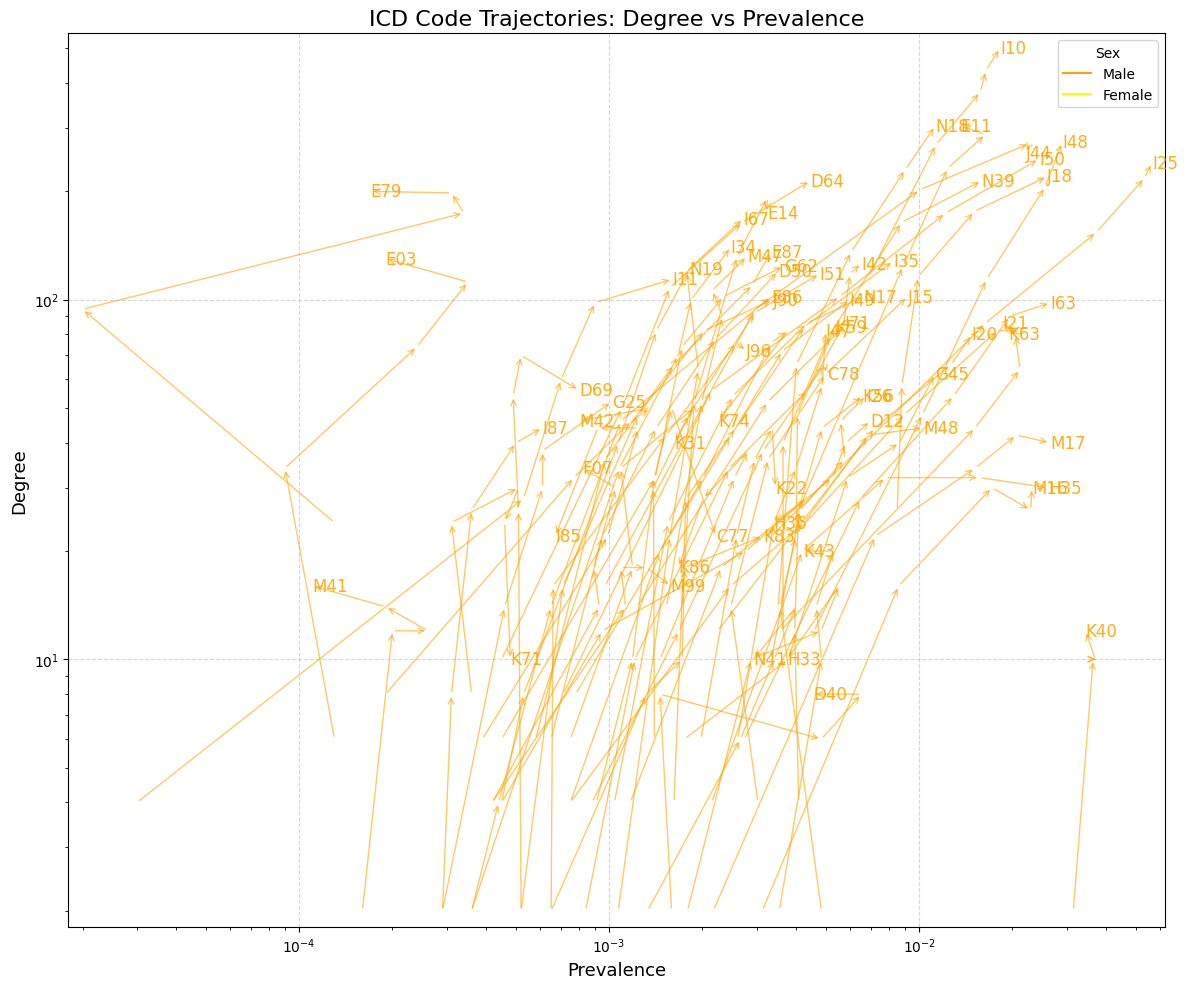

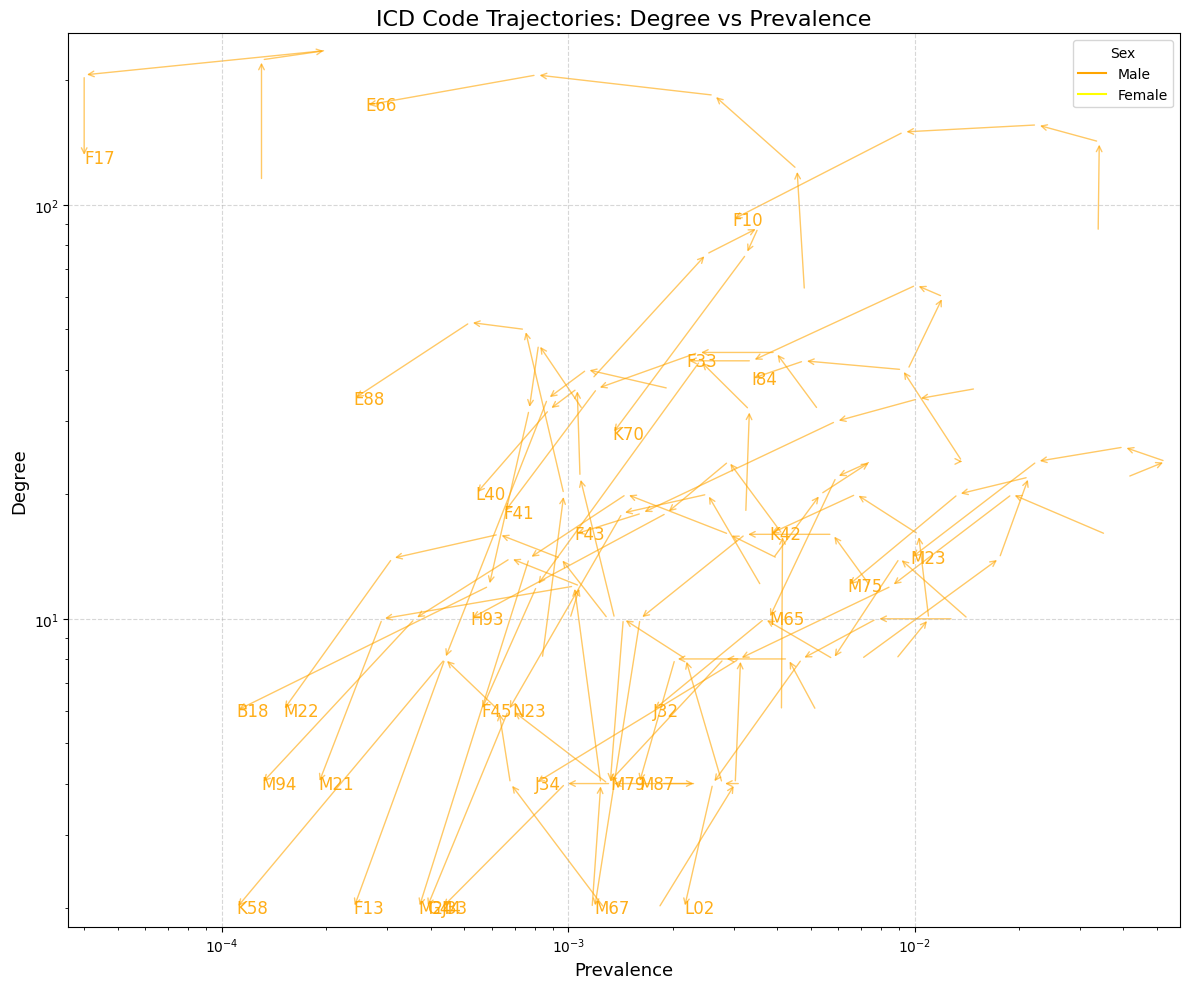

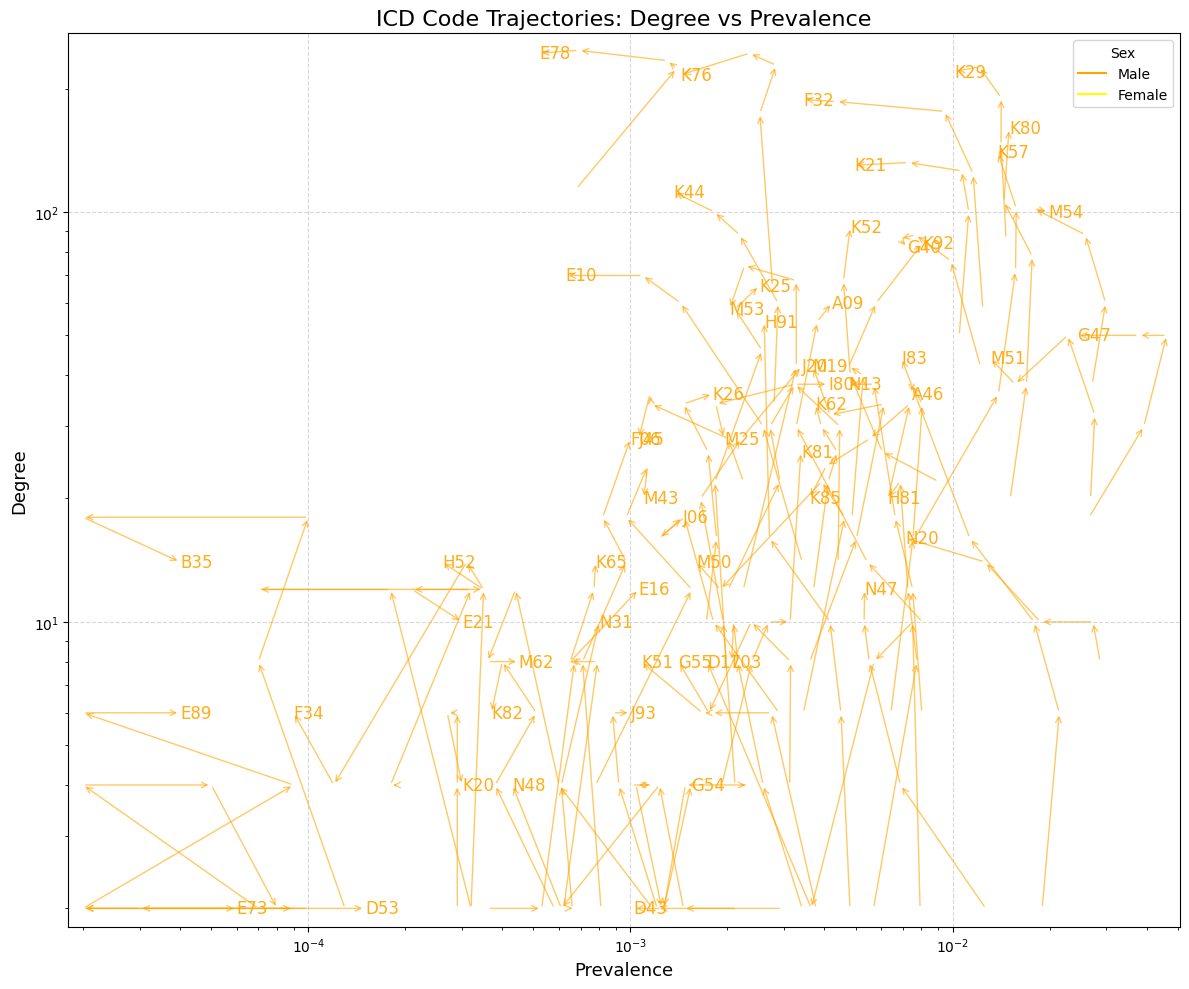

In [97]:
df_traj.dropna(subset='DTW_Cluster', inplace=True)
plot_all_icd_trajectories(df_traj[df_traj['DTW_Cluster']==0], 'Male', 1E-10, 1E-10, blocks=False, weighted=False)#, clusters=True)
plot_all_icd_trajectories(df_traj[df_traj['DTW_Cluster']==1], 'Male', 1E-10, 1E-10, blocks=False, weighted=False)#, clusters=True)
plot_all_icd_trajectories(df_traj[df_traj['DTW_Cluster']==2], 'Male', 1E-10, 1E-10, blocks=False, weighted=False)#, clusters=True)

In [136]:
import numpy as np
import pandas as pd
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesResampler
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import Optional

def normalize_trajectory(traj):
    return (traj - traj.mean(axis=0)) / traj.std(axis=0)

def trajectory_deltas(traj):
    return np.diff(traj, axis=0)

def elbow_method_dtw(trajectories, max_clusters=10, n_points=10, normalize=True, use_deltas=True, plot=True):
    processed = []
    for traj in trajectories:
        if use_deltas:
            traj = trajectory_deltas(traj)
        if normalize:
            traj = normalize_trajectory(traj)
        processed.append(traj)
    
    input_len = n_points - 1 if use_deltas else n_points
    ts_array = TimeSeriesResampler(sz=input_len).fit_transform(np.array(processed))
    #fins nans or empty in ts_array
    if np.isnan(ts_array).any():
        #find the nans
        nan_indices = np.argwhere(np.isnan(ts_array))
        #set nans to zero
        ts_array[nan_indices[:, 0], nan_indices[:, 1]] = 0
            
            
    inertias = []
    for k in range(1, max_clusters + 1):
        model = TimeSeriesKMeans(n_clusters=k, metric="dtw", random_state=0)
        model.fit(ts_array)
        inertias.append(model.inertia_)

    if plot:
        plt.figure(figsize=(8, 5))
        plt.plot(range(1, max_clusters + 1), inertias, marker='o')
        plt.xlabel("Number of clusters (k)")
        plt.ylabel("DTW Inertia")
        plt.title("Elbow Method for DTW Clustering")
        plt.grid(True)
        plt.show()

    # Heuristic elbow: max second derivative
    diffs = np.diff(inertias)
    elbow_k = np.argmax(np.diff(diffs)) + 2  # +2 because diff twice and 1-indexed
    return elbow_k, inertias

def cluster_icd_trajectories_with_elbow(
    df, 
    min_age_index=4, 
    n_clusters: Optional[int] = None, 
    max_clusters: int = 10, 
    n_points: int = 10,
    normalize=False,
    use_deltas=False,
    auto_select_k=True
):
    df_out = df.copy()
    df_out['DTW_Cluster'] = np.nan
    
    df = df[df['Degree'] > 0]
    df = df[df['Prevalence'] > 0]
    df['Degree'] = df['Degree'].apply(lambda x: np.log10(x))
    df['Prevalence'] = df['Prevalence'].apply(lambda x: np.log10(x))

    for sex in ['Male', 'Female']:
        df_sex = df[(df['Sex'] == sex) & (df['Age_Index'] >= min_age_index)]

        age_groups = df_sex['Age_Index'].unique()
        icd_counts = df_sex.groupby('ICD_Code')['Age_Index'].nunique()
        valid_icds = icd_counts[icd_counts == len(age_groups)].index

        df_valid = df_sex[df_sex['ICD_Code'].isin(valid_icds)]

        icd_trajectories = {}
        for icd in valid_icds:
            df_icd = df_valid[df_valid['ICD_Code'] == icd].sort_values('Age_Index')
            trajectory = df_icd[['Degree', 'Prevalence']].to_numpy()
            icd_trajectories[icd] = trajectory

        all_trajectories = list(icd_trajectories.values())

        # Apply elbow method if auto_select_k
        if auto_select_k or n_clusters is None:
            optimal_k, inertias = elbow_method_dtw(
                all_trajectories,
                max_clusters=max_clusters,
                n_points=n_points,
                normalize=normalize,
                use_deltas=use_deltas
            )
            k = optimal_k
            print(f"[{sex}] Optimal number of clusters from elbow method: {k}")
        else:
            k = n_clusters

        # Final preprocessing for clustering
        processed = []
        for traj in all_trajectories:
            if use_deltas:
                traj = trajectory_deltas(traj)
            if normalize:
                traj = normalize_trajectory(traj)
            processed.append(traj)

        input_len = n_points - 1 if use_deltas else n_points
        ts_array = TimeSeriesResampler(sz=input_len).fit_transform(np.array(processed))

        model = TimeSeriesKMeans(n_clusters=k, metric="dtw", random_state=0)
        labels = model.fit_predict(ts_array)

        icd_list = list(icd_trajectories.keys())
        for icd_code, label in zip(icd_list, labels):
            idx = (df_out['Sex'] == sex) & (df_out['ICD_Code'] == icd_code) & (df_out['Age_Index'] >= min_age_index)
            df_out.loc[idx, 'DTW_Cluster'] = label

    df_out['DTW_Cluster'] = df_out['DTW_Cluster'].astype('Int64')
    return df_out

C:\Users\Giovanni Palermo\AppData\Local\Temp\ipykernel_15420\4102817144.py:10: RuntimeWarning: invalid value encountered in divide
  return (traj - traj.mean(axis=0)) / traj.std(axis=0)


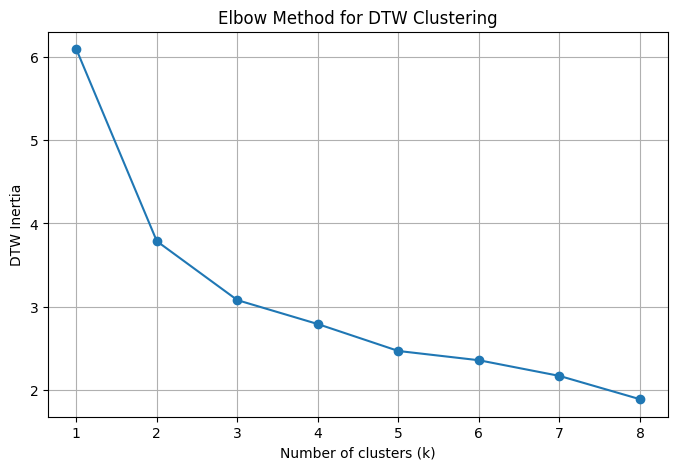

[Male] Optimal number of clusters from elbow method: 2


C:\Users\Giovanni Palermo\AppData\Local\Temp\ipykernel_15420\4102817144.py:10: RuntimeWarning: invalid value encountered in divide
  return (traj - traj.mean(axis=0)) / traj.std(axis=0)


ValueError: One of the input time series contains only nans or has zero length.

In [137]:
df_clustered = cluster_icd_trajectories_with_elbow(
    df_traj,
    min_age_index=4,
    max_clusters=8,        # check up to 8 clusters
    n_clusters=None,       # not fixed
    auto_select_k=True,    # use elbow method
    normalize=True,
    use_deltas=True
)
